In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, LSTM, Flatten
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess



# Caricamento e pulizia del dataset

In [ ]:
# Leggere il file originale
df = pd.read_csv('RECENSIONI.csv')
print("Numero di valori NaN in ciascuna colonna prima della rimozione:")
print(df.isnull().sum())

# Rimuovere righe con valori mancanti
df = df.dropna()
print("Numero di valori NaN in ciascuna colonna dopo la rimozione:")
print(df.isnull().sum())

# Salvare il DataFrame pulito senza valori NaN
df.to_csv('RECENSIONI.csv', index=False)

# Ricaricare il DataFrame pulito
df = pd.read_csv('RECENSIONI.csv')


Numero di valori NaN in ciascuna colonna prima della rimozione:
User     0
Stars    7
Date     0
Text     0
Title    0
dtype: int64
Numero di valori NaN in ciascuna colonna dopo la rimozione:
User     0
Stars    0
Date     0
Text     0
Title    0
dtype: int64


# Analisi esplorativa dei dati

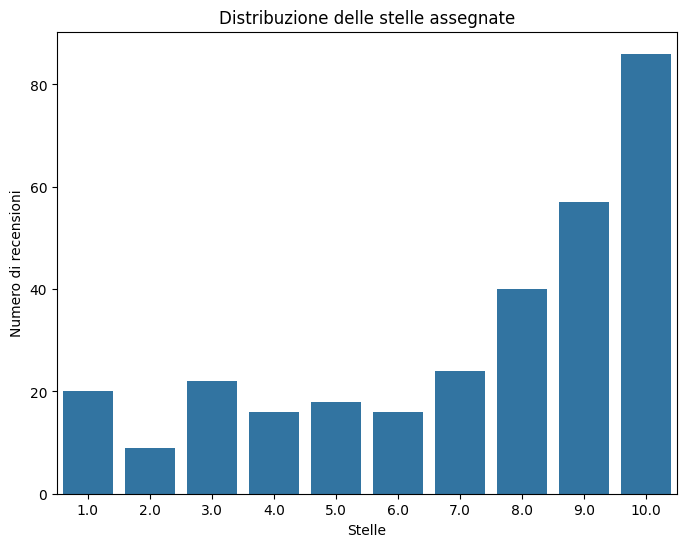

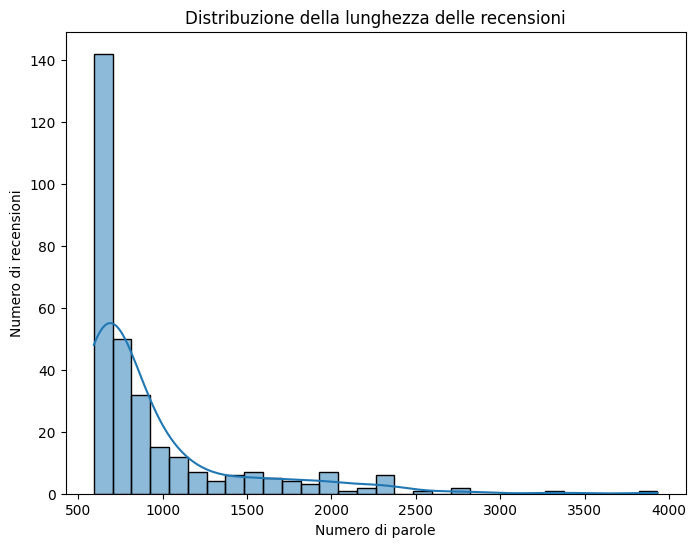

In [ ]:

df = pd.read_csv('RECENSIONI.csv')
# Distribuzione delle stelle assegnate
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='Stars')
plt.title('Distribuzione delle stelle assegnate')
plt.xlabel('Stelle')
plt.ylabel('Numero di recensioni')
plt.show()

# Lunghezza delle recensioni
df['Review_Length'] = df['Text'].apply(len)
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='Review_Length', bins=30, kde=True)
plt.title('Distribuzione della lunghezza delle recensioni')
plt.xlabel('Numero di parole')
plt.ylabel('Numero di recensioni')
plt.show()

# Pre-elaborazione

In [ ]:
# Scarica i dati di WordNet necessari
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('stopwords')

# Carica il dataset originale
df = pd.read_csv('RECENSIONI.csv')

# Funzione per la rimozione della punteggiatura
def remove_punctuation(text):
    return re.sub(r'[^\w\s]', '', text)

# Applica la rimozione della punteggiatura
df['Text'] = df['Text'].apply(remove_punctuation)

# Conversione in lowercase
df['Text'] = df['Text'].str.lower()

# Rimozione dei caratteri non alfabetici
def remove_non_alphabet(text):
    return re.sub('[^a-z ]+', '', text)

df['Text'] = df['Text'].apply(remove_non_alphabet)

# Funzione per rimuovere le stopwords
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    words = word_tokenize(text)
    words_filtered = [word for word in words if word not in stop_words]
    return ' '.join(words_filtered)

# Applica la rimozione delle stopwords
df['Text'] = df['Text'].apply(remove_stopwords)

# Controlla le recensioni pulite
print("Esempi di recensioni dopo la rimozione delle stopwords:")
print(df['Text'].head())

# Salva il dataframe pulito
df.to_csv('RECENSIONI_pulite.csv', index=False)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Esempi di recensioni dopo la rimozione delle stopwords:
0    dosent get renewed season imagine plenty peopl...
1    gentleman spin movie name movie great big star...
2    big fan guy ritchie movie based gentleman ive ...
3    reminder tv freaking fun take seriously gentle...
4    thoroughly enjoyed series although acknowledge...
Name: Text, dtype: object


# Definizione soglie per il sentiment


In [ ]:
# Definizione delle soglie per il sentiment
positive_threshold = 7
negative_threshold = 6

# Funzione per etichettare il sentiment in base al numero di stelle
def label_sentiment(stars):
    if stars <= negative_threshold:
        return 0 #negative
    elif stars >= positive_threshold:
        return 1 #positive
    else:
        return None  # Per gestire eventuali valori fuori dai range specificati

# Creazione della nuova colonna 'Sentiment' basata sulle stelle
df['Sentiment'] = df['Stars'].apply(label_sentiment)

# Visualizzazione delle prime righe del DataFrame con la nuova colonna 'Sentiment'
print(df[['Stars', 'Sentiment']].head())
print(df[['Stars', 'Sentiment']].tail())

# Verifica dei valori di 'Sentiment' nel DataFrame originale prima di salvarlo
print("Conteggio dei sentiment nel DataFrame originale:")
print(df['Sentiment'].value_counts(dropna=False))

# Salvataggio del DataFrame e rilettura del file CSV
df.to_csv('RECENSIONI_pulite.csv', index=False)
df = pd.read_csv('RECENSIONI_pulite.csv')

# Verifica la presenza di valori NaN nella colonna 'Sentiment' dopo la rilettura del CSV
print("Numero di valori NaN in 'Sentiment':", df['Sentiment'].isna().sum())


   Stars  Sentiment
0    9.0          1
1    9.0          1
2    9.0          1
3   10.0          1
4    9.0          1
     Stars  Sentiment
303    1.0          0
304    3.0          0
305    4.0          0
306    3.0          0
307    4.0          0
Conteggio dei sentiment nel DataFrame originale:
Sentiment
1    207
0    101
Name: count, dtype: int64
Numero di valori NaN in 'Sentiment': 0


# Definizione del dataset di train e test

In [ ]:
x_data= df['Text']
y_data= df['Sentiment']
#split dataset
x_train, x_test, y_train, y_test= train_test_split(x_data,y_data,test_size=0.2,random_state= 42)

In [ ]:
# Controllo della distribuzione delle classi
print("Distribuzione delle classi nel training set:")
print(y_train.value_counts())
print("Distribuzione delle classi nel test set:")
print(y_test.value_counts())


Distribuzione delle classi nel training set:
Sentiment
1    167
0     79
Name: count, dtype: int64
Distribuzione delle classi nel test set:
Sentiment
1    40
0    22
Name: count, dtype: int64


# Tokenizzazione e Padding

In [ ]:
# Inizializza e adatta il Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

# Calcola il numero totale di parole uniche nel vocabolario
num_words = len(tokenizer.word_index) + 1  # Considera una parola in più per il padding

# Trasforma i testi in sequenze di token
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_test_seq = tokenizer.texts_to_sequences(x_test)

#Trova la lunghezza massima delle sequenze
max_length = max(len(seq) for seq in x_train_seq)

# Applica il padding alle sequenze
x_train_padded = pad_sequences(x_train_seq, maxlen=max_length, padding='post', truncating='post')
x_test_padded = pad_sequences(x_test_seq, maxlen=max_length, padding='post', truncating='post')

# Verifica le dimensioni dei dati di addestramento e test dopo il padding
print("Dimensioni dei dati di addestramento dopo il padding:", x_train_padded.shape)
print("Dimensioni dei dati di test dopo il padding:", x_test_padded.shape)


Dimensioni dei dati di addestramento dopo il padding: (246, 357)
Dimensioni dei dati di test dopo il padding: (62, 357)


#  1. Trasformazione dei testi in vettori numerici: Bag Of Words, TF-IDF(Term Frequency-Inverse Document Frequency) e Word2Vec

### BoW

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

#Inizializza il vettorizzatore BoW
bow_vectorizer = CountVectorizer()

# Adatta il vettorizzatore BoW ai dati di addestramento e trasforma i dati
x_train_bow = bow_vectorizer.fit_transform(x_train)
x_test_bow = bow_vectorizer.transform(x_test)

# Stampa le dimensioni dei dati vettorizzati BoW
print("Dimensioni dei dati di addestramento vettorizzati con BoW:", x_train_bow.shape)
print("Dimensioni dei dati di test vettorizzati con BoW:", x_test_bow.shape)


Dimensioni dei dati di addestramento vettorizzati con BoW: (246, 5427)
Dimensioni dei dati di test vettorizzati con BoW: (62, 5427)


## TFIDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Inizializza il vettorizzatore TF-IDF
tfidf_vectorizer = TfidfVectorizer()

# Adatta il vettorizzatore TF-IDF ai dati di addestramento e trasforma i dati
x_train_tfidf = tfidf_vectorizer.fit_transform(x_train)
x_test_tfidf = tfidf_vectorizer.transform(x_test)

# Stampa le dimensioni dei dati vettorizzati TF-IDF
print("Dimensioni dei dati di addestramento vettorizzati con TF-IDF:", x_train_tfidf.shape)
print("Dimensioni dei dati di test vettorizzati con TF-IDF:", x_test_tfidf.shape)

Dimensioni dei dati di addestramento vettorizzati con TF-IDF: (246, 5427)
Dimensioni dei dati di test vettorizzati con TF-IDF: (62, 5427)


## Word2Vec

In [ ]:
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
import numpy as np

# Prepara i dati per il training di Word2Vec
corpus_train = [simple_preprocess(text) for text in x_train]
corpus_test = [simple_preprocess(text) for text in x_test]

# Addestra il modello Word2Vec
word2vec_model = Word2Vec(sentences=corpus_train, vector_size=300, window=5, min_count=1, workers=4)

# Vettorizza i dati di addestramento e di test
def document_vector(word2vec_model, doc):
    """ Calcola il vettore del documento """
    doc = [word for word in doc if word in word2vec_model.wv.index_to_key]
    return np.mean(word2vec_model.wv[doc], axis=0)

x_train_w2v = np.array([document_vector(word2vec_model, doc) for doc in corpus_train])
x_test_w2v = np.array([document_vector(word2vec_model, doc) for doc in corpus_test])

# Stampa le dimensioni dei dati vettorizzati Word2Vec
print("Dimensioni dei dati di addestramento vettorizzati con Word2Vec:", x_train_w2v.shape)
print("Dimensioni dei dati di test vettorizzati con Word2Vec:", x_test_w2v.shape)


Dimensioni dei dati di addestramento vettorizzati con Word2Vec: (246, 300)
Dimensioni dei dati di test vettorizzati con Word2Vec: (62, 300)


# SMOTE

### Applicazione di SMOTE solo sui dati di addestramento

In [ ]:
# Applicazione di SMOTE solo sui dati di addestramento
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
x_train_bow_smote, y_train_bow_smote = smote.fit_resample(x_train_bow, y_train)
x_train_tfidf_smote, y_train_tfidf_smote = smote.fit_resample(x_train_tfidf, y_train)



### Valutazione dei modelli con cross-validation stratificata per ogni vettorizzazione e con dati SMOTE

In [ ]:
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
# Valutazione dei modelli con cross-validation stratificata per ogni vettorizzazione e con dati SMOTE
# Definizione dei modelli
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "SVM": SVC(),
    "Random Forest": RandomForestClassifier(),
    "KNN": KNeighborsClassifier()
}
scoring = ['accuracy', 'precision', 'recall', 'f1']

vectorizers = {
    "BoW": (x_train_bow_smote, x_test_bow, y_train_bow_smote),
    "TF-IDF": (x_train_tfidf_smote, x_test_tfidf, y_train_tfidf_smote)
}

for vectorizer_name, (x_train_vec, x_test_vec, y_train_vec_smote) in vectorizers.items():
    print(f"Vettorizzazione: {vectorizer_name}")
    for model_name, model in models.items():
        print(f"Modello: {model_name}")
        stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        results = cross_validate(model, x_train_vec, y_train_vec_smote, cv=stratified_kfold, scoring=scoring)
        mean_accuracy = np.mean(results['test_accuracy'])
        mean_precision = np.mean(results['test_precision'])
        mean_recall = np.mean(results['test_recall'])
        mean_f1 = np.mean(results['test_f1'])
        print(f"Accuracy (mean): {mean_accuracy}")
        print(f"Precision (mean): {mean_precision}")
        print(f"Recall (mean): {mean_recall}")
        print(f"F1-score (mean): {mean_f1}")
        print()

Vettorizzazione: BoW
Modello: Logistic Regression
Accuracy (mean): 0.8413387607417457
Precision (mean): 0.8684650316930629
Recall (mean): 0.8085561497326204
F1-score (mean): 0.8334721495867704

Modello: Naive Bayes
Accuracy (mean): 0.8592944369063771
Precision (mean): 0.8437195484254307
Recall (mean): 0.886096256684492
F1-score (mean): 0.8633786520872828

Modello: SVM
Accuracy (mean): 0.8353686114880144
Precision (mean): 0.76590472549966
Recall (mean): 0.970409982174688
F1-score (mean): 0.8554789199852492

Modello: Random Forest
Accuracy (mean): 0.8056083220262324
Precision (mean): 0.8459518792191206
Recall (mean): 0.7484848484848484
F1-score (mean): 0.7914559094275119

Modello: KNN
Accuracy (mean): 0.5029850746268656
Precision (mean): 0.2
Recall (mean): 0.006060606060606061
F1-score (mean): 0.011764705882352943

Vettorizzazione: TF-IDF
Modello: Logistic Regression


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defin

Accuracy (mean): 0.9341022161917684
Precision (mean): 0.9132719430552247
Recall (mean): 0.9638146167557933
F1-score (mean): 0.9359687403833794

Modello: Naive Bayes
Accuracy (mean): 0.9251922207146087
Precision (mean): 0.9560483870967742
Recall (mean): 0.8921568627450981
F1-score (mean): 0.9226678697646438

Modello: SVM
Accuracy (mean): 0.8983717774762552
Precision (mean): 0.83335656213705
Recall (mean): 1.0
F1-score (mean): 0.9084138784093018

Modello: Random Forest
Accuracy (mean): 0.8715061058344642
Precision (mean): 0.8129755538579069
Recall (mean): 0.9759358288770054
F1-score (mean): 0.8852709558192668

Modello: KNN


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defin

Accuracy (mean): 0.5
Precision (mean): 0.0
Recall (mean): 0.0
F1-score (mean): 0.0



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Addestramento e valutazione dei modelli con dati SMOTE e BoW + matrice di confusione

Modello: Logistic Regression


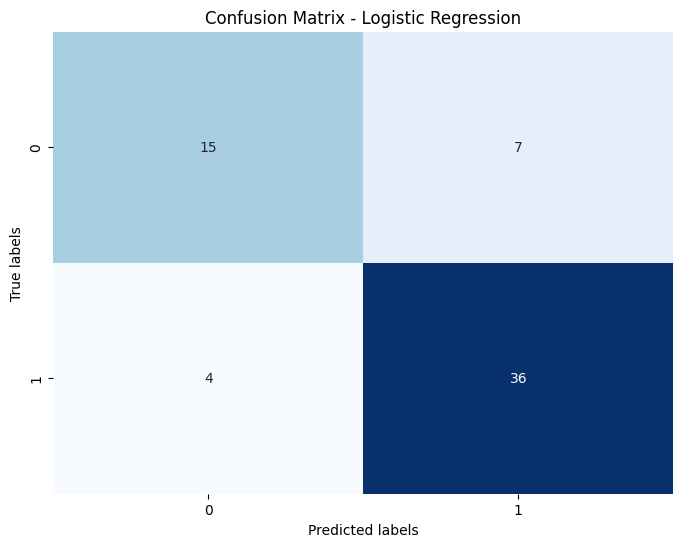

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.68      0.73        22
           1       0.84      0.90      0.87        40

    accuracy                           0.82        62
   macro avg       0.81      0.79      0.80        62
weighted avg       0.82      0.82      0.82        62

Modello: Naive Bayes


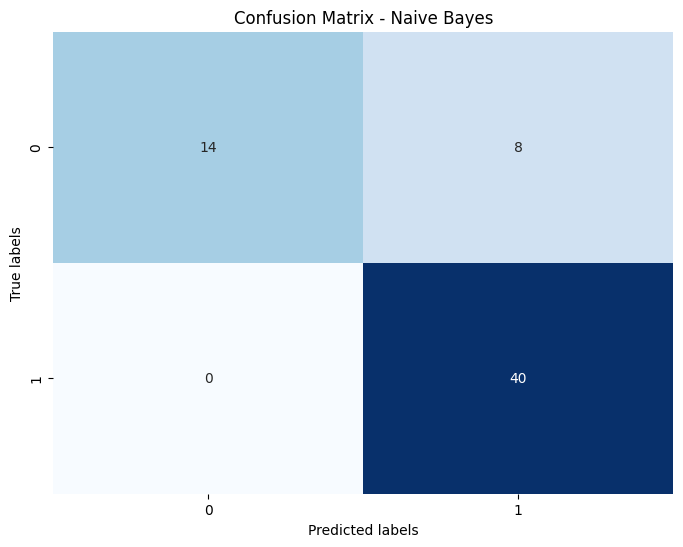

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.64      0.78        22
           1       0.83      1.00      0.91        40

    accuracy                           0.87        62
   macro avg       0.92      0.82      0.84        62
weighted avg       0.89      0.87      0.86        62

Modello: SVM


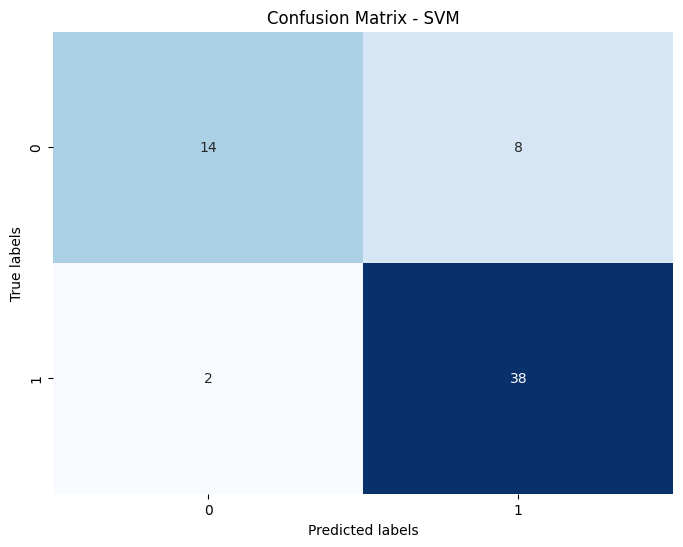

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.64      0.74        22
           1       0.83      0.95      0.88        40

    accuracy                           0.84        62
   macro avg       0.85      0.79      0.81        62
weighted avg       0.84      0.84      0.83        62

Modello: Random Forest


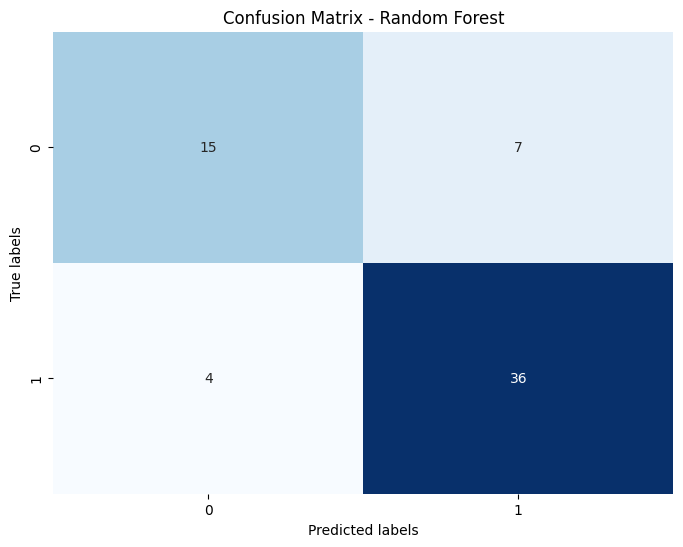

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.68      0.73        22
           1       0.84      0.90      0.87        40

    accuracy                           0.82        62
   macro avg       0.81      0.79      0.80        62
weighted avg       0.82      0.82      0.82        62

Modello: KNN


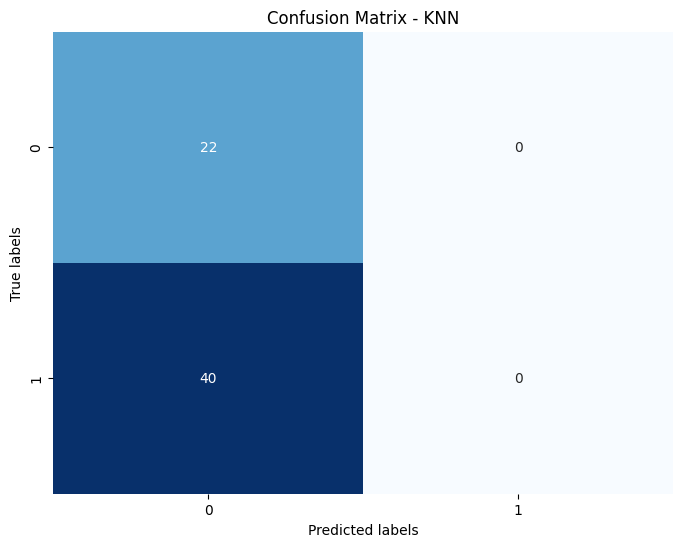

Classification Report:
              precision    recall  f1-score   support

           0       0.35      1.00      0.52        22
           1       0.00      0.00      0.00        40

    accuracy                           0.35        62
   macro avg       0.18      0.50      0.26        62
weighted avg       0.13      0.35      0.19        62



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Addestramento e valutazione dei modelli con dati SMOTE e BoW
for model_name, model in models.items():
    print(f"Modello: {model_name}")
    # Addestramento del modello completo sui dati di addestramento SMOTE BoW
    model.fit(x_train_bow_smote, y_train_bow_smote)
    # Predizioni sui dati di test
    y_pred = model.predict(x_test_bow)
    # Calcolo della matrice di confusione
    conf_matrix = confusion_matrix(y_test, y_pred)
    # Plot della matrice di confusione
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()
    # Rapporto di classificazione
    class_report = classification_report(y_test, y_pred)
    print("Classification Report:")
    print(class_report)


### Addestramento e valutazione dei modelli con dati SMOTE e TF-IDF + Matrici di confusione

Modello: Logistic Regression


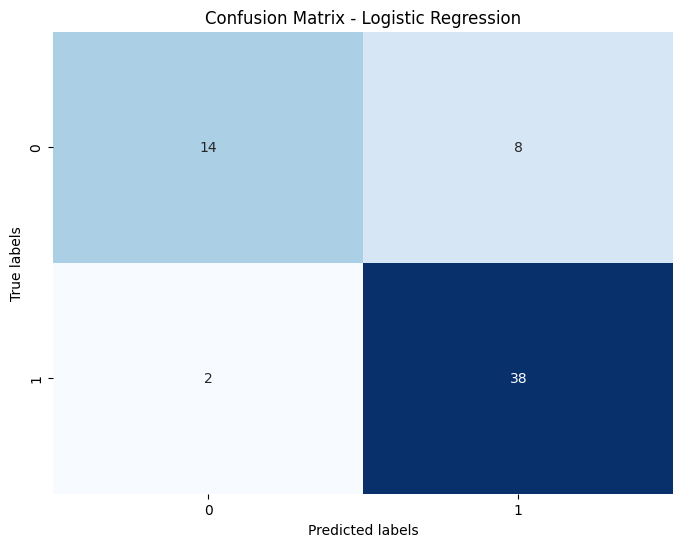

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.64      0.74        22
           1       0.83      0.95      0.88        40

    accuracy                           0.84        62
   macro avg       0.85      0.79      0.81        62
weighted avg       0.84      0.84      0.83        62

Modello: Naive Bayes


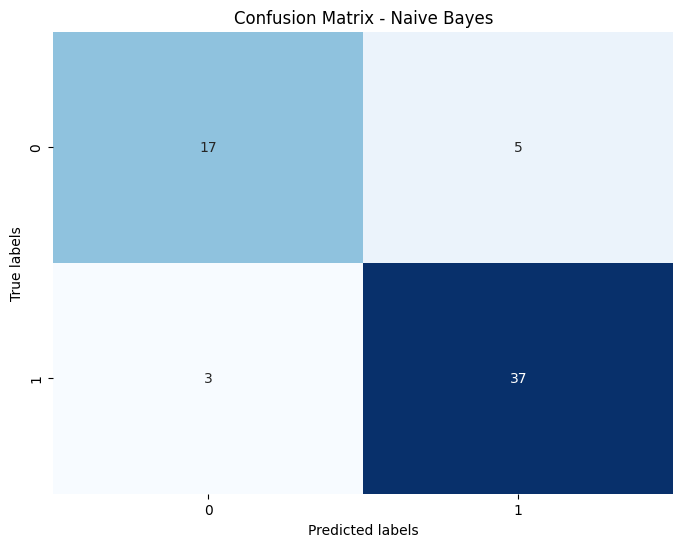

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.77      0.81        22
           1       0.88      0.93      0.90        40

    accuracy                           0.87        62
   macro avg       0.87      0.85      0.86        62
weighted avg       0.87      0.87      0.87        62

Modello: SVM


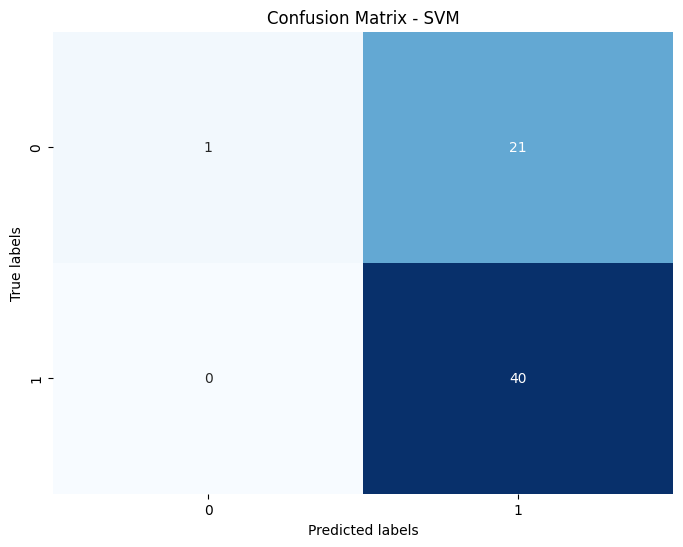

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.05      0.09        22
           1       0.66      1.00      0.79        40

    accuracy                           0.66        62
   macro avg       0.83      0.52      0.44        62
weighted avg       0.78      0.66      0.54        62

Modello: Random Forest


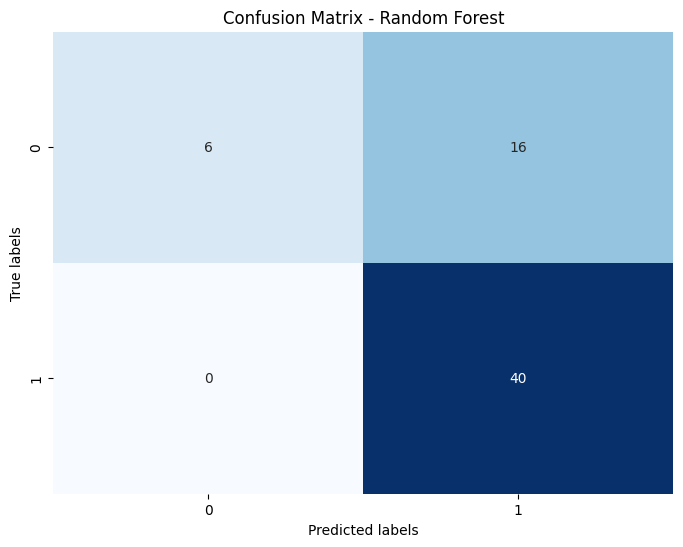

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.27      0.43        22
           1       0.71      1.00      0.83        40

    accuracy                           0.74        62
   macro avg       0.86      0.64      0.63        62
weighted avg       0.82      0.74      0.69        62

Modello: KNN


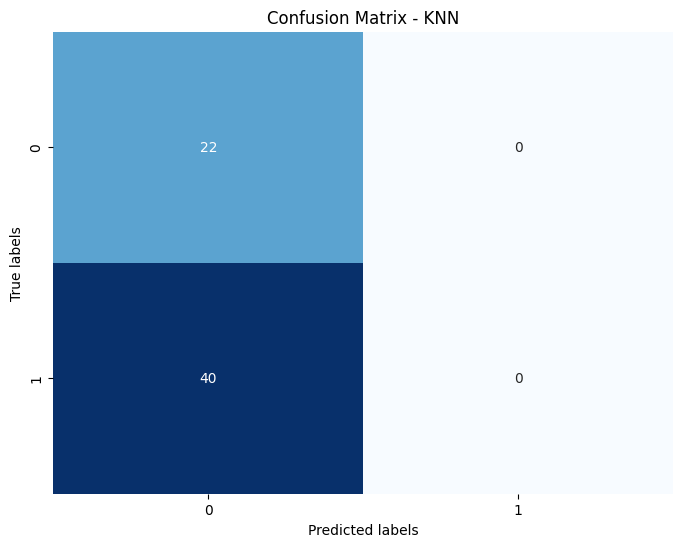

Classification Report:
              precision    recall  f1-score   support

           0       0.35      1.00      0.52        22
           1       0.00      0.00      0.00        40

    accuracy                           0.35        62
   macro avg       0.18      0.50      0.26        62
weighted avg       0.13      0.35      0.19        62



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Addestramento e valutazione dei modelli con dati SMOTE e TF-IDF
for model_name, model in models.items():
    print(f"Modello: {model_name}")
    # Addestramento del modello completo sui dati di addestramento SMOTE TF-IDF
    model.fit(x_train_tfidf_smote, y_train_tfidf_smote)
    # Predizioni sui dati di test
    y_pred = model.predict(x_test_tfidf)
    # Calcolo della matrice di confusione
    conf_matrix = confusion_matrix(y_test, y_pred)
    # Plot della matrice di confusione
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()
    # Rapporto di classificazione
    class_report = classification_report(y_test, y_pred)
    print("Classification Report:")
    print(class_report)



### Reshape e Applicazione di SMOTE con Word2Vec

In [ ]:
# Reshape dei dati di addestramento Word2Vec
x_train_w2v_reshaped = x_train_w2v.reshape((x_train_w2v.shape[0], -1))

# Applicazione di SMOTE solo sui dati di addestramento Word2Vec
smote = SMOTE(random_state=42)
x_train_w2v_smote, y_train_w2v_smote = smote.fit_resample(x_train_w2v_reshaped, y_train)


### Valutazione dei modelli con cross-validation stratificata per Word2Vec e con dati SMOTE

In [ ]:
# Valutazione dei modelli con cross-validation stratificata per Word2Vec e con dati SMOTE
print("Vettorizzazione: Word2Vec")
for model_name, model in models.items():
    if model_name == "Naive Bayes":  # Naive Bayes non compatibile con Word2Vec
        continue
    print(f"Modello: {model_name}")
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    results = cross_validate(model, x_train_w2v_smote, y_train_w2v_smote, cv=stratified_kfold, scoring=scoring)
    mean_accuracy = np.mean(results['test_accuracy'])
    mean_precision = np.mean(results['test_precision'])
    mean_recall = np.mean(results['test_recall'])
    mean_f1 = np.mean(results['test_f1'])
    print(f"Accuracy (mean): {mean_accuracy}")
    print(f"Precision (mean): {mean_precision}")
    print(f"Recall (mean): {mean_recall}")
    print(f"F1-score (mean): {mean_f1}")
    print()


Vettorizzazione: Word2Vec
Modello: Logistic Regression
Accuracy (mean): 0.5419267299864314
Precision (mean): 0.7120397428404441
Recall (mean): 0.5376114081996435
F1-score (mean): 0.46955802495774446

Modello: SVM
Accuracy (mean): 0.5479421076436002
Precision (mean): 0.5805116959064327
Recall (mean): 0.3233511586452763
F1-score (mean): 0.4125565356231867

Modello: Random Forest
Accuracy (mean): 0.8262777023971053
Precision (mean): 0.8356345897941824
Recall (mean): 0.813903743315508
F1-score (mean): 0.8209154146230417

Modello: KNN
Accuracy (mean): 0.6407960199004974
Precision (mean): 0.819496336996337
Recall (mean): 0.3345811051693405
F1-score (mean): 0.4716811594202898



### Matrice di confusione con word2vec

Modello: Logistic Regression


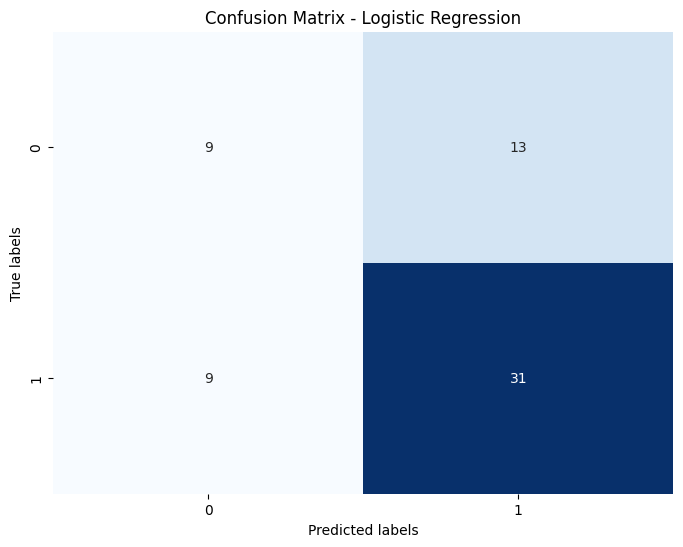

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.41      0.45        22
           1       0.70      0.78      0.74        40

    accuracy                           0.65        62
   macro avg       0.60      0.59      0.59        62
weighted avg       0.63      0.65      0.64        62

Modello: SVM


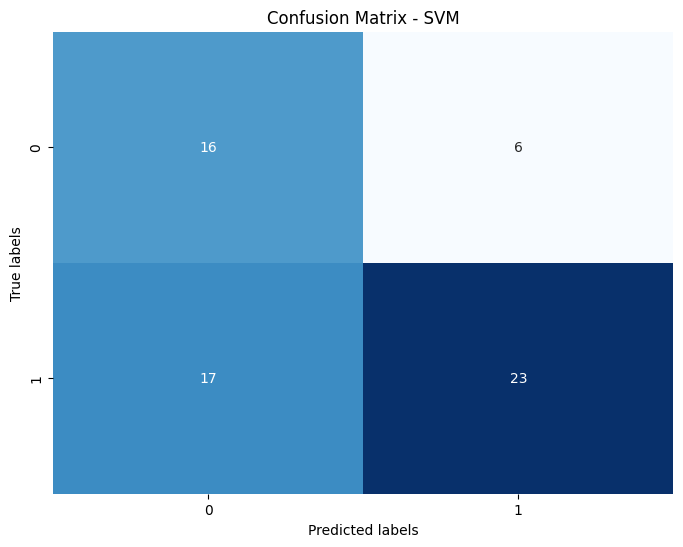

Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.73      0.58        22
           1       0.79      0.57      0.67        40

    accuracy                           0.63        62
   macro avg       0.64      0.65      0.62        62
weighted avg       0.68      0.63      0.64        62

Modello: Random Forest


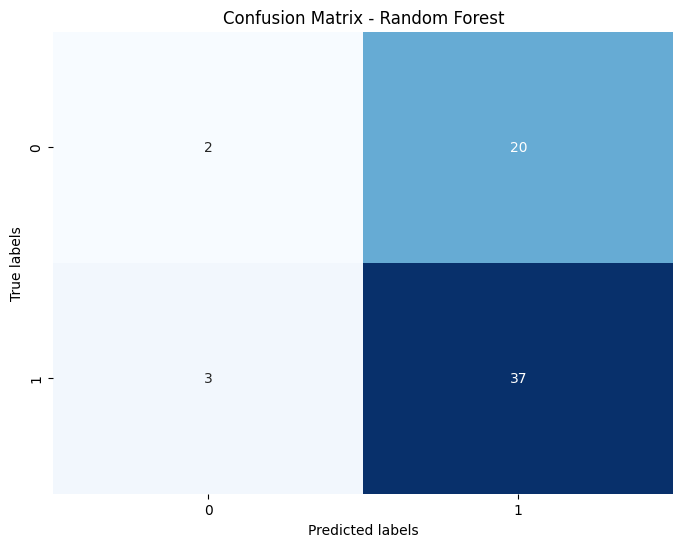

Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.09      0.15        22
           1       0.65      0.93      0.76        40

    accuracy                           0.63        62
   macro avg       0.52      0.51      0.46        62
weighted avg       0.56      0.63      0.54        62

Modello: KNN


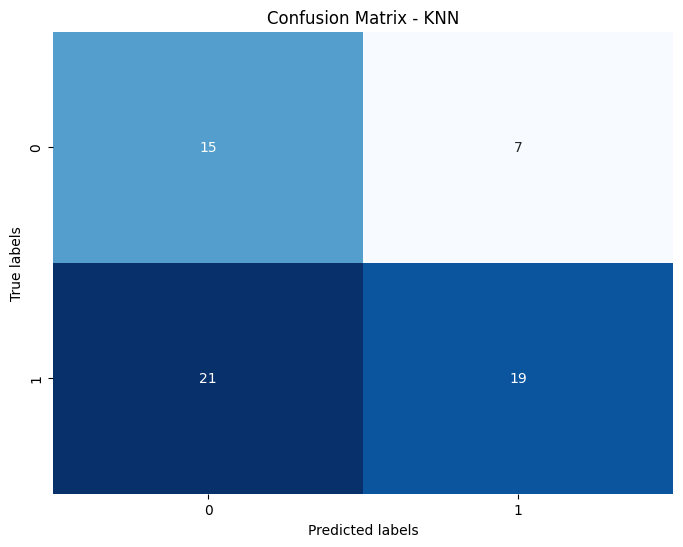

Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.68      0.52        22
           1       0.73      0.47      0.58        40

    accuracy                           0.55        62
   macro avg       0.57      0.58      0.55        62
weighted avg       0.62      0.55      0.55        62



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Addestramento e valutazione dei modelli con dati SMOTE e Word2Vec
for model_name, model in models.items():
    if model_name == "Naive Bayes":  # Naive Bayes non compatibile con Word2Vec
        continue
    print(f"Modello: {model_name}")
    # Addestramento del modello completo sui dati di addestramento SMOTE Word2Vec
    model.fit(x_train_w2v_smote, y_train_w2v_smote)
    # Predizioni sui dati di test
    y_pred = model.predict(x_test_w2v)
    # Calcolo della matrice di confusione
    conf_matrix = confusion_matrix(y_test, y_pred)
    # Plot della matrice di confusione
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()
    # Rapporto di classificazione
    class_report = classification_report(y_test, y_pred)
    print("Classification Report:")
    print(class_report)


##  Valutazione Performance dei Modelli tramite Cross-Validation Stratificata:
 La stratificazione garantisce che ogni fold abbia una distribuzione simile delle classi di target, il che può portare a stime più affidabili delle prestazioni del modello. Considerando che stai lavorando con dati di recensioni, che potrebbero essere soggetti a sbilanciamento delle classi, l'uso della cross-validation stratificata è una scelta appropriata e può portare a stime più accurate delle prestazioni del modello

In [ ]:
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Definizione dei modelli
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "SVM": SVC(),
    "Random Forest": RandomForestClassifier(),
    "KNN": KNeighborsClassifier()
}

# Definizione delle vettorizzazioni
vectorizers = {
    "BoW": (x_train_bow, x_test_bow),
    "TF-IDF": (x_train_tfidf, x_test_tfidf),
    "Word2Vec": (x_train_w2v, x_test_w2v)
}

# Definizione delle misure di performance
scoring = ['accuracy', 'precision', 'recall', 'f1']

# Valutazione dei modelli con cross-validation stratificata per ogni vettorizzazione
for vectorizer_name, (x_train_vec, x_test_vec) in vectorizers.items():
    print(f"Vettorizzazione: {vectorizer_name}")
    for model_name, model in models.items():
        if model_name == "Naive Bayes" and vectorizer_name == "Word2Vec":
            continue  # Salta Naive Bayes con Word2Vec
        print(f"Modello: {model_name}")
        stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        results = cross_validate(model, x_train_vec, y_train, cv=stratified_kfold, scoring=scoring)
        mean_accuracy = np.mean(results['test_accuracy'])
        std_accuracy = np.std(results['test_accuracy'])
        mean_precision = np.mean(results['test_precision'])
        std_precision = np.std(results['test_precision'])
        mean_recall = np.mean(results['test_recall'])
        std_recall = np.std(results['test_recall'])
        mean_f1 = np.mean(results['test_f1'])
        std_f1 = np.std(results['test_f1'])
        print(f"Accuracy (mean): {mean_accuracy}")
        print(f"Accuracy (std): {std_accuracy}")
        print(f"Precision (mean): {mean_precision}")
        print(f"Precision (std): {std_precision}")
        print(f"Recall (mean): {mean_recall}")
        print(f"Recall (std): {std_recall}")
        print(f"F1-score (mean): {mean_f1}")
        print(f"F1-score (std): {std_f1}")
        print()
    print()


Vettorizzazione: BoW
Modello: Logistic Regression
Accuracy (mean): 0.8171428571428571
Accuracy (std): 0.031127634228469567
Precision (mean): 0.8188104007255854
Precision (std): 0.04673626379943468
Recall (mean): 0.9467023172905525
Recall (std): 0.05395625053969607
F1-score (mean): 0.8756520632766444
F1-score (std): 0.01962450778131024

Modello: Naive Bayes
Accuracy (mean): 0.8087346938775509
Accuracy (std): 0.05313000252067309
Precision (mean): 0.8262324929971989
Precision (std): 0.05503712710193044
Recall (mean): 0.9158645276292334
Recall (std): 0.04037580712913113
F1-score (mean): 0.8672322166041294
F1-score (std): 0.03448124511757865

Modello: SVM
Accuracy (mean): 0.6748571428571428
Accuracy (std): 0.010847010770202826
Precision (mean): 0.6775510204081632
Precision (std): 0.008163265306122458
Recall (mean): 0.9941176470588236
Recall (std): 0.011764705882352944
F1-score (mean): 0.8058183955333529
F1-score (std): 0.007706488022641702

Modello: Random Forest
Accuracy (mean): 0.71551020

# Rete neurale con vettori Word2Vec

In [ ]:
# Importazioni necessarie
import numpy as np
from keras.models import Sequential
from keras.layers import SimpleRNN, Dropout, Dense, Conv1D, MaxPooling1D, Flatten, LSTM
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score, f1_score
from keras.preprocessing.sequence import pad_sequences

# Funzione per compilare e addestrare il modello
def compile_and_train(model, x_train, y_train, x_test, y_test, epochs=10, batch_size=32):
    model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test))
    score = model.evaluate(x_test, y_test, verbose=0)
    y_pred = (model.predict(x_test) > 0.5).astype("int32")
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"Test loss: {score[0]}, Test accuracy: {accuracy}, F1-score: {f1}")
    return accuracy, f1

# Modello RNN
rnn_model = Sequential([
    SimpleRNN(128, input_shape=(max_length, 1), return_sequences=True),
    Dropout(0.2),
    SimpleRNN(128),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

print("Training RNN model...")
rnn_accuracy, rnn_f1 = compile_and_train(rnn_model, x_train_padded, y_train, x_test_padded, y_test)

# Modello CNN
cnn_model = Sequential([
    Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(max_length, 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

print("Training CNN model...")
cnn_accuracy, cnn_f1 = compile_and_train(cnn_model, x_train_padded, y_train, x_test_padded, y_test)

# Modello LSTM
lstm_model = Sequential([
    LSTM(128, input_shape=(max_length, 1), return_sequences=True),
    Dropout(0.2),
    LSTM(128),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

print("Training LSTM model...")
lstm_accuracy, lstm_f1 = compile_and_train(lstm_model, x_train_padded, y_train, x_test_padded, y_test)

# Stampa dei risultati
print(f"RNN Model - Accuracy: {rnn_accuracy}, F1-score: {rnn_f1}")
print(f"CNN Model - Accuracy: {cnn_accuracy}, F1-score: {cnn_f1}")
print(f"LSTM Model - Accuracy: {lstm_accuracy}, F1-score: {lstm_f1}")

# Predizioni sui dati di test
y_pred_rnn = (rnn_model.predict(x_test_padded) > 0.5).astype("int32")
y_pred_cnn = (cnn_model.predict(x_test_padded) > 0.5).astype("int32")
y_pred_lstm = (lstm_model.predict(x_test_padded) > 0.5).astype("int32")



Training RNN model...
Epoch 1/10
8/8 [==============================] - 10s 514ms/step - loss: 0.6878 - accuracy: 0.6179 - val_loss: 0.6645 - val_accuracy: 0.6452
Epoch 2/10
8/8 [==============================] - 4s 465ms/step - loss: 0.6378 - accuracy: 0.6504 - val_loss: 0.6705 - val_accuracy: 0.6452
Epoch 3/10
8/8 [==============================] - 6s 821ms/step - loss: 0.6413 - accuracy: 0.6789 - val_loss: 0.6633 - val_accuracy: 0.6452
Epoch 4/10
8/8 [==============================] - 10s 1s/step - loss: 0.6799 - accuracy: 0.6138 - val_loss: 0.6560 - val_accuracy: 0.6452
Epoch 5/10
8/8 [==============================] - 9s 1s/step - loss: 0.6734 - accuracy: 0.5894 - val_loss: 0.6655 - val_accuracy: 0.6452
Epoch 6/10
8/8 [==============================] - 7s 792ms/step - loss: 0.6502 - accuracy: 0.6748 - val_loss: 0.6504 - val_accuracy: 0.6452
Epoch 7/10
8/8 [==============================] - 4s 468ms/step - loss: 0.6823 - accuracy: 0.5894 - val_loss: 0.6693 - val_accuracy: 0.6452
Ep

# Matrice di confusione per valutare le prestazioni del modello

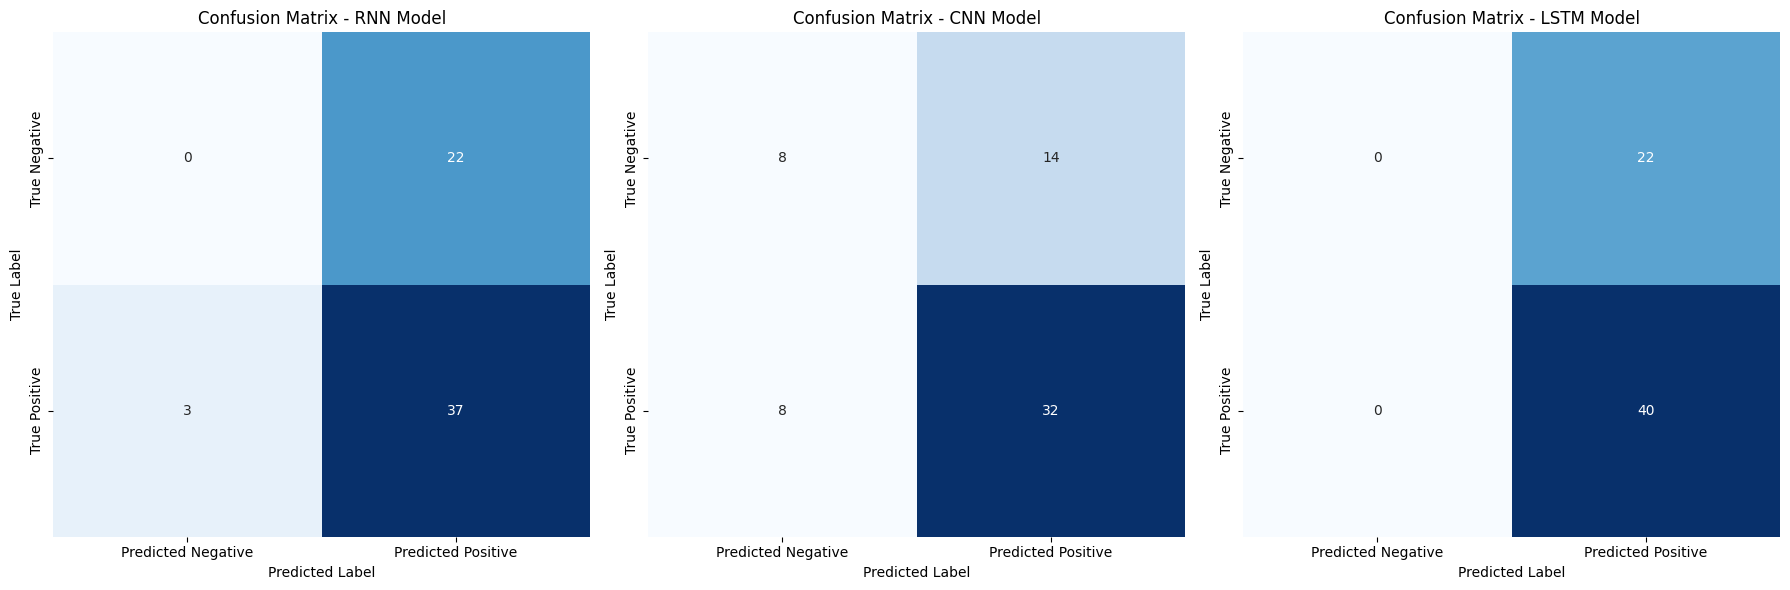

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Definisci i nomi dei modelli e le relative previsioni
model_names = ['RNN', 'CNN', 'LSTM']
y_preds = [y_pred_rnn, y_pred_cnn, y_pred_lstm]

# Crea una griglia di subplot per le matrici di confusione
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Per ogni modello, calcola e visualizza la matrice di confusione
for i, (model_name, y_pred) in enumerate(zip(model_names, y_preds)):
    conf_matrix = confusion_matrix(y_test, y_pred)
    conf_df = pd.DataFrame(conf_matrix, index=['True Negative', 'True Positive'], columns=['Predicted Negative', 'Predicted Positive'])
    sns.heatmap(conf_df, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[i])
    axes[i].set_title(f'Confusion Matrix - {model_name} Model')
    axes[i].set_xlabel('Predicted Label')
    axes[i].set_ylabel('True Label')

plt.tight_layout()
plt.show()


c'è una tendenza nello scegliere il positivo al posto del negativo

#TRANSFORMERS

## BERT

In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

# Definizione dei parametri
MAX_LEN = 512  # Lunghezza massima della sequenza
BATCH_SIZE = 32
LEARNING_RATE = 2e-5
EPOCHS = 3

# Caricamento dei dati di addestramento e test
df= pd.read_csv('RECENSIONI_pulite.csv')
texts = df['Text']
labels = df['Sentiment']

# Tokenizzazione dei testi
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
input_ids = []
attention_masks = []

for text in texts:
    encoded_dict = tokenizer.encode_plus(
                        text,                      # Testo da tokenizzare
                        add_special_tokens = True, # Aggiunge [CLS] e [SEP]
                        max_length = MAX_LEN,      # Imposta la lunghezza massima della sequenza
                        padding = 'max_length',    # Padding della sequenza
                        return_attention_mask = True,   # Crea le attention mask
                        return_tensors = 'pt',     # Restituisce i tensori di PyTorch
                   )

    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Divisione dei dati in set di addestramento e di validazione
train_inputs, val_inputs, train_labels, val_labels = train_test_split(input_ids, labels,
                                                            random_state=2022, test_size=0.1)
train_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2022, test_size=0.1)

# Creazione di DataLoader per il set di addestramento e di validazione
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE)

# Caricamento del modello BERT pre-addestrato per la classificazione di sequenze
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 2,
    output_attentions = False,
    output_hidden_states = False,
)

# Definizione del device per l'addestramento su GPU, se disponibile
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Definizione dell'ottimizzatore e del scheduler
optimizer = AdamW(model.parameters(),
                  lr = LEARNING_RATE,
                  eps = 1e-8
                )

total_steps = len(train_dataloader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

# Addestramento del modello
for epoch in range(EPOCHS):
    model.train()
    total_train_loss = 0

    for step, batch in enumerate(train_dataloader):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()
        outputs = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask,
                    labels=b_labels)

        loss = outputs.loss
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)

    # Valutazione del modello sul set di validazione
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0

    for batch in val_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask,
                            labels=b_labels)

            loss = outputs.loss
            logits = outputs.logits

        total_eval_loss += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        total_eval_accuracy += accuracy_score(np.argmax(logits, axis=1), label_ids)

    avg_val_accuracy = total_eval_accuracy / len(val_dataloader)
    avg_val_loss = total_eval_loss / len(val_dataloader)

    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print(f'Training Loss: {avg_train_loss:.4f}')
    print(f'Validation Loss: {avg_val_loss:.4f}')
    print(f'Validation Accuracy: {avg_val_accuracy:.4f}')

print("Addestramento completato!")


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3
Training Loss: 0.6177
Validation Loss: 0.6658
Validation Accuracy: 0.6129
Epoch 2/3
Training Loss: 0.5474
Validation Loss: 0.5262
Validation Accuracy: 0.6774
Epoch 3/3
Training Loss: 0.4782
Validation Loss: 0.5040
Validation Accuracy: 0.6452
Addestramento completato!


# GPT-2

In [ ]:
data = pd.read_csv('RECENSIONI_pulite.csv')
import torch
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification
from sklearn.model_selection import train_test_split

# Tokenizer e modello GPT-2
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token  # Aggiungi il token di padding
model = GPT2ForSequenceClassification.from_pretrained('gpt2', num_labels=2)
model.config.pad_token_id = tokenizer.pad_token_id  # Configura il modello per usare il token di padding

# Tokenizzazione e encoding delle recensioni
def encode_reviews(reviews, tokenizer, max_length=512):
    return tokenizer(reviews, padding=True, truncation=True, max_length=max_length, return_tensors='pt')

# Prepara i dati
reviews = data['Text'].tolist()
labels = data['Sentiment'].apply(lambda x: 1 if x == 'positivo' else 0).tolist()  # Supponiamo che i sentimenti siano "positivo" e "negativo"

# Suddivisione in train e test
train_texts, test_texts, train_labels, test_labels = train_test_split(reviews, labels, test_size=0.2, random_state=42)

# Encoding dei dati
train_encodings = encode_reviews(train_texts, tokenizer)
test_encodings = encode_reviews(test_texts, tokenizer)

train_labels = torch.tensor(train_labels)
test_labels = torch.tensor(test_labels)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW
import numpy as np

# Creazione dei DataLoader
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels)
test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], test_labels)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)

# Ottimizzatore
optimizer = AdamW(model.parameters(), lr=5e-5)

# Funzione di training
def train(model, train_loader, optimizer, epochs=3):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(model.device), attention_mask.to(model.device), labels.to(model.device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
        avg_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch + 1} completed with average loss: {avg_loss:.4f}')

# Sposta il modello sulla GPU se disponibile
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Addestra il modello
train(model, train_loader, optimizer)


Epoch 1 completed with average loss: 0.0212
Epoch 2 completed with average loss: 0.0000
Epoch 3 completed with average loss: 0.0000


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Funzione di valutazione
def evaluate(model, test_loader):
    model.eval()
    preds, true_labels = [], []
    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(model.device), attention_mask.to(model.device), labels.to(model.device)
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds.extend(torch.argmax(logits, dim=1).tolist())
            true_labels.extend(labels.tolist())
    accuracy = accuracy_score(true_labels, preds)
    return preds, true_labels, accuracy

# Ottieni le predizioni
y_pred, y_true, accuracy = evaluate(model, test_loader)

# Calcola la matrice di confusione
conf_matrix = confusion_matrix(y_true, y_pred)

# Stampa la matrice di confusione, l'accuratezza e il rapporto di classificazione
print('Matrice di confusione:')
print(conf_matrix)

print('Accuratezza:', accuracy)

print('Rapporto di classificazione:')
print(classification_report(y_true, y_pred))


Matrice di confusione:
[[62]]
Accuratezza: 1.0
Rapporto di classificazione:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        62

    accuracy                           1.00        62
   macro avg       1.00      1.00      1.00        62
weighted avg       1.00      1.00      1.00        62

